# Tarea 3 - Parte 1.2
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

In [1]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import keras
import time

from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model

from keras.layers import Reshape,Conv2DTranspose,Activation
from keras import backend as K

import os
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape)
img_rows, img_cols = X_train.shape[1:]
channel  = 1
#img_rows, img_cols = X_train.shape[1:]


#img_rows, img_cols,channel = X_train.shape[:]

(60000, 28, 28)


In [4]:
X_train = np.reshape(X_train, (len(X_train), 28, 28,1)) #modify for th dim ordering
X_test = np.reshape(X_test, (len(X_test), 28, 28,1))

In [5]:
#X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]),1,1))
#X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:]),1,1))
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### a) Defina al *discriminador* de la GAN como el que se muestra en el código, de 3 bloque convolucionales y una tanda *fully conected*, con los Dropout para evitar *overfitting*. Describa la arquitectura utilizada y cuál es la función de activación seleccionada.

In [6]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
lr_alpha = 0.02

#D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same'))
D.add(LeakyReLU(alpha=lr_alpha))      
D.add(Dropout(dropout))
      
#D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same'))      
D.add(LeakyReLU(alpha=lr_alpha))      
D.add(Dropout(dropout))
      
#D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same'))      
D.add(LeakyReLU(alpha=lr_alpha))
D.add(Dropout(dropout))
D.add(Flatten())

#D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1024))
D.add(LeakyReLU(alpha=lr_alpha))      

D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

**Arquitectura**
* Como entrada la imagen, después 3 capas convolucionales con dropout antes de pasar a la siguiente. La primera cada tiene  64 filtros, la segunda 128  y la tercera 256. En las tres capas convolucionales el kernel es 5x5 y se utiliza stride=2.
* Luego tiene una capa fltten que lineariza el resultado de las convoluciones, siendo la entrada  para la siguiente capa totalmente conectada con 1024 unidades ocultas.
* Finalmente, la última capa es una única neurona.
* Todas las funciones de activación son leakyRelu, con parámetro alpha=0.2, excepto la última capa que tiene activación sigmoid.
* Esta última capa representa la probabilidad infeida por el discriminador, siendo un valor entre 0 y 1.

### b) Defina al generador de la GAN como el que se muestra en el código, con una tanda fully conected y 3 bloque convolucionales transpuesta además de agregar BatchNormalization entre ellas para tener un aprendizaje más estable. Describa la arquitectura utilizada (siendo del tipo fully convolutional puesto que la salida es un arreglo n-dimensional) y el porqué la función de activación de la salida es sigmoidal.

In [7]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE

#G.add(Dense(128, input_dim=input_dim))
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))


G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Reshape((dim, dim, depth)))

G.add(Conv2DTranspose(depth/2, (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Conv2DTranspose(depth/2, (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
__________

** Arquitectura**
* Toma como entrada dos valores que se suponde son muestreados de la distribución latente, y los conecta con una capa densa de 128 unidades, luego viene otra capa densa con que $dim*dim*depth$ unidades que corresponde a la versión lieanrizada de la imagen que se esta generando. Luego se redimensiona ese vector como una matriz cuadrada de $dim*dim*depth$. Luego se aplican tres capas de convolución transpuesta que van haciendo un upscaling hasta llegar al tamaño final de la imagen generada. Los parámetros corresponden al inverso del discriminador, en cuanto a número de  filtros por ejemplo. Y finalmente se aplica una activación sigmoid para fomentar que los pixeles tomen colores definidos, por ejemplo blancos o negros en vez de grises, para generar una imagen más nitida.
En todas las capas de utiliza batch normalization para obtener un espacio mas estable.

* Sigmoid se utiliza en la última capa para poder reducir la dimensioanalidad y poder generar la imagen artificial.
Como tambien ruerza a los pixeles a tener un valor bien definido entre ser negro o blanco, evitando colores como grieses.



### c) Conecte los modelos a través del enfoque adversario, será necesario definir dos modelos debido a que el entrenamiento es iterativo, primero se entrena el discriminador el generador fijo, luego se entrena el generador con el discriminador fijo y así.

In [8]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)

D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

### d) Entrene el modelo definido con el enfoque iterativo como se nombró, para ésto utilice la función que se presenta que lo realiza de manera manual. Grafique la pérdida loss de cada red (el generador y el discriminador/adversario) a través de los pasos de actualización de los pesos ¿Cómo se espera que sean estas curvas de aprendizaje?

Al graficar el loss de cada red uno esperaría, en base a la teoría, que el discriminador alcanza un nivel constante de pérdida, cuando su accuracy llega al valor 0.5, es decir que no es mejor que el azar al discriminar, y por ende ya no puede tener mayor ni menor loss. 

Por otro lado, el nivel de pérdida del generador también, en el caso óptimo, debe llegar a un estado de oscilación constante ya que pasa a recibir respuestas del discriminador que no son mejores que el azar, es decir con precision 0.5, y por tanto el generador ya no podría seguir mejorando. Esto es efectivamente lo que ocurre al graficar el loss luego de los entrenamientos en los puntos siguientes.

In [9]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size, input_dim):
    history = {"d":[],"g":[]}
    print(steps)
    start_time = time.time()
    for e in range(steps):
        #print("e: %s" % e)
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        if e % 1000 == 0:
            log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
            log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
            print(log_mesg)
    end_time = time.time()
    total_time = end_time - start_time
    return history, total_time

train_steps = 5000 #or few if  you want
hist, time_d = train_on_steps(X_train,DM,AM,G,train_steps,64, input_dim)

5000


/home/srodriguez/miniconda/envs/python27/lib/python2.7/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.700207, acc: 0.492188]  [G loss: 2.259525, acc: 0.000000]
1000: [D loss: 0.300020, acc: 0.875000]  [G loss: 0.784308, acc: 0.562500]
2000: [D loss: 0.345370, acc: 0.859375]  [G loss: 1.992800, acc: 0.171875]
3000: [D loss: 0.346891, acc: 0.835938]  [G loss: 1.732757, acc: 0.140625]
4000: [D loss: 0.274798, acc: 0.914062]  [G loss: 0.481180, acc: 0.781250]


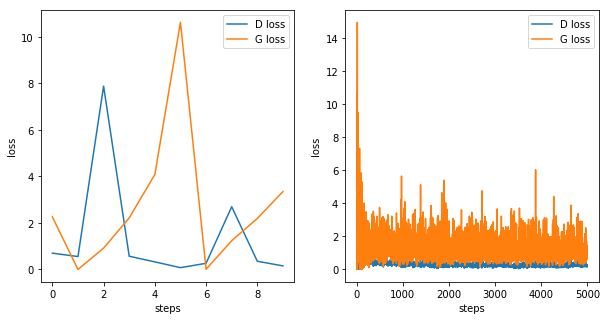

In [10]:
hist_d_loss = [item for item in map(lambda x: x[0], hist['d'])]
hist_g_loss = [item for item in map(lambda x: x[0], hist['g'])]

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(hist_d_loss[0:10])
plt.plot(hist_g_loss[0:10])
plt.legend(['D loss', 'G loss'])
plt.xlabel('steps')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(hist_d_loss)
plt.plot(hist_g_loss)
plt.legend(['D loss', 'G loss'])
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

###  e) Genere nuevos datos artificialmente a través del modelo generador *G* ya entrenado, para esto inicialice aleatoriamente el espacio oculto de dimensiones del generador a través de una distribución Uniforme entre -1 y 1, al igual como fue entrenado. Comente sobre las imágenes generadas y compare con lo realizado con el VAE, en temas de calidad visual y en tiempos de ejecución.

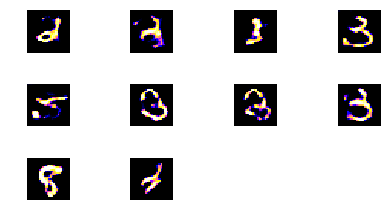

In [11]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gnuplot2')
    plt.axis('off')
plt.tight_layout()
plt.show()

**Comentario**

Las imágenes generadas tienen un leve parecido con las originales, pero definitivamente su calidad visual es inferior a las generadas por el VAE. Quizás un punto a favor de estas imágenes que son más "definidas" en el sentido que no tienen esos halos de color rosado.

### f) ¿Qué le parece que resulta más crucial al momento de entrenar las GAN, saber que se tiene un buen generador e intentar mejorar el discriminador o saber que se tiene un buen discriminador e intentar mejorar el generador? en ambos casos para que el generador mejore. Experimente con una de las ideas, modifique el generador o el discriminador e intente generar mejores imágenes artificiales.

Se podría pensar que un buen discriminador va a permitir entrenar cualquier generador hasta su máximo potencial. A continuación se trata de hacer un mejor discriminador cambiando las capas de Dropout por una de BatchNormalization.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         819456    
__________

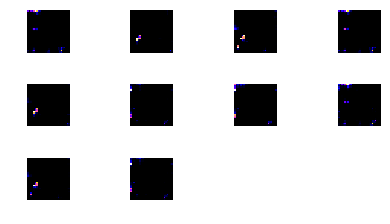

In [12]:
## Discriminator
D2 = Sequential()
d2_depth = 64
d2_dropout = 0.4
input_shape = (img_rows, img_cols, channel)
d2_lr_alpha = 0.02

D2.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape, padding='same'))
D2.add(LeakyReLU(alpha=lr_alpha))      
#D.add(Dropout(dropout))
D2.add(BatchNormalization())


D2.add(Conv2D(depth*2, (5,5), strides=2, padding='same'))      
D2.add(LeakyReLU(alpha=lr_alpha))      
#D.add(Dropout(dropout))
D2.add(BatchNormalization())

D2.add(Conv2D(depth*4, (5,5), strides=2, padding='same'))      
D2.add(LeakyReLU(alpha=lr_alpha))
#D.add(Dropout(dropout))
D2.add(BatchNormalization())

D2.add(Flatten())

#D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D2.add(Dense(1024))
D2.add(BatchNormalization())

D2.add(LeakyReLU(alpha=lr_alpha))      

D2.add(Dense(1,activation='sigmoid'))
D2.summary()

optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM2 = Sequential()
DM2.add(D2)
DM2.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

D2.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM2 = Sequential()
AM2.add(G)
AM2.add(D2)
AM2.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

hist, time_f = train_on_steps(X_train,DM2,AM2,G,train_steps,64, input_dim)

N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gnuplot2')
    plt.axis('off')
plt.tight_layout()
plt.show()

** Comentario **

Al parecer el discriminador generado es demasiado exigente y preciso, logra accuracy 1.0, y ocurrió quizás algún overfitting que no logró un mejor generador.

### g) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida, diferente a la Uniforme, e **implementela** entrenando completamente el modelo.

Para cambiar la distribución latente de los datos es necesario reemplazar el código donde samplea de la distribución uniforme, para que el muestreo salga de otra distribución

In [13]:
def train_on_steps_norm(X_train,DM,AM,G,steps,batch_size, input_dim):
    history = {"d":[],"g":[]}
    start_time = time.time()
    for e in range(steps):
        # Make generative images        
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data

        ##noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        ## Sampling de distribucion normal con media 0 y desv estandar 1
        noise_gen = np.random.normal(0, 1, size=[batch_size, input_dim])

        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        
        # train Generator-Discriminator stack on input noise to non-generated output class        
        #noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        noise_tr = np.random.normal(0, 1, size=[batch_size,input_dim])

        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        if e % 1000 == 0:
            log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
            log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
            print(log_mesg)
    
    end_time = time.time()
    total_time = end_time - start_time
    return history, total_time
    
train_steps = 5000 #or few if  you want
hist, time_g = train_on_steps_norm(X_train,DM,AM,G,train_steps,64, input_dim)

0: [D loss: 0.148494, acc: 0.945312]  [G loss: 3.266486, acc: 0.000000]
1000: [D loss: 0.187117, acc: 0.929688]  [G loss: 0.913400, acc: 0.609375]
2000: [D loss: 0.121262, acc: 0.960938]  [G loss: 1.153277, acc: 0.515625]
3000: [D loss: 0.169462, acc: 0.898438]  [G loss: 0.850254, acc: 0.578125]
4000: [D loss: 0.118179, acc: 0.968750]  [G loss: 0.573440, acc: 0.718750]


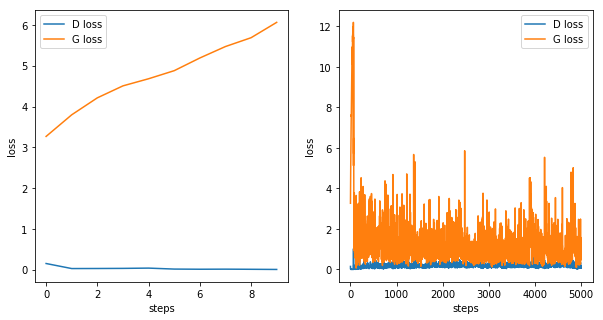

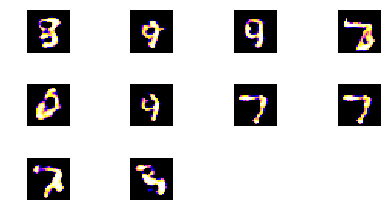

In [14]:
hist_d_loss = [item for item in map(lambda x: x[0], hist['d'])]
hist_g_loss = [item for item in map(lambda x: x[0], hist['g'])]

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(hist_d_loss[0:10])
plt.plot(hist_g_loss[0:10])
plt.legend(['D loss', 'G loss'])
plt.xlabel('steps')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(hist_d_loss)
plt.plot(hist_g_loss)
plt.legend(['D loss', 'G loss'])
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

N = 10
##noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
noise = np.random.normal(0, 1, size=[N,input_dim])

images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gnuplot2')
    plt.axis('off')
plt.tight_layout()
plt.show()

**Comentario**

En comparación con las imágenes generadas en el punto e se podría decir que estas imagenes son mejores, ya que están un poco más definidas y se parecen más a las originales. Siguen siendo inferiores a las generadas por el VAE, en todo caso. Se puede concluir también que la distribución latente sí tiene impacto en la calidad de las imágenes generadas.

### h) Comente sobre el efecto de aumentar la dimensionalidad de las variables a generar datos $z$. Compare con lo acontecido con el método generativo VAE.

Para aumentar la dimensionalidad solo hay que modificar el generador, cambiando la variable input_dim. Se modifica a 4 ingual que como se hizo en VAE.

In [15]:
## Generator
G2 = Sequential()
dim = 14
input_dim_g2 = 4 #2 #para que sea similar al vAE

G2.add(Dense(128, input_dim=input_dim_g2))
G2.add(BatchNormalization())
G2.add(Activation('relu'))

G2.add(Dense(dim*dim*depth))
G2.add(BatchNormalization())
G2.add(Activation('relu'))

G2.add(Reshape((dim, dim, depth)))

G2.add(Conv2DTranspose(depth/2, (3,3), padding='same',strides=(2,2)))
G2.add(BatchNormalization())
G2.add(Activation('relu'))

G2.add(Conv2DTranspose(depth/2, (3,3), padding='same'))
G2.add(BatchNormalization())
G2.add(Activation('relu'))

G2.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G2.add(Activation('sigmoid')) 
G2.summary()

optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM2 = Sequential()
AM2.add(G2)
AM2.add(D)
AM2.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_10 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_7 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 64)        0         
__________

6000
0: [D loss: 0.018592, acc: 1.000000]  [G loss: 7.008023, acc: 0.000000]
1000: [D loss: 0.398836, acc: 0.843750]  [G loss: 1.322935, acc: 0.156250]
2000: [D loss: 0.340182, acc: 0.851562]  [G loss: 1.921448, acc: 0.109375]
3000: [D loss: 0.367445, acc: 0.804688]  [G loss: 2.638875, acc: 0.078125]
4000: [D loss: 0.266962, acc: 0.859375]  [G loss: 1.570938, acc: 0.250000]
5000: [D loss: 0.191729, acc: 0.929688]  [G loss: 1.226031, acc: 0.390625]


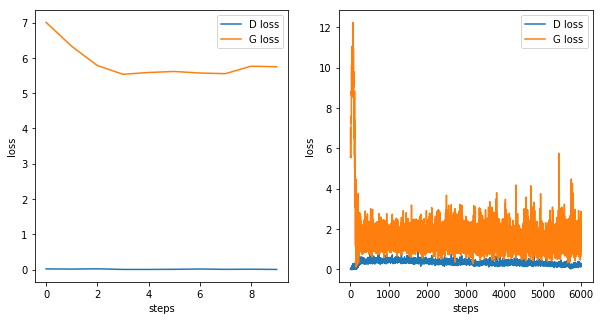

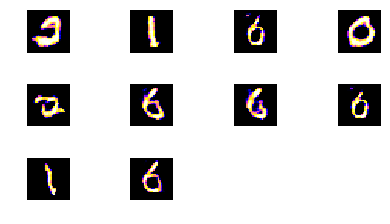

In [16]:
## Entrenamos el modelo con discriminador D y generador G2
train_steps = 6000 #or few if  you want
hist, time_h = train_on_steps(X_train,DM,AM2,G2,train_steps,64, input_dim_g2)

hist_d_loss = [item for item in map(lambda x: x[0], hist['d'])]
hist_g_loss = [item for item in map(lambda x: x[0], hist['g'])]

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(hist_d_loss[0:10])
plt.plot(hist_g_loss[0:10])
plt.legend(['D loss', 'G loss'])
plt.xlabel('steps')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(hist_d_loss)
plt.plot(hist_g_loss)
plt.legend(['D loss', 'G loss'])
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim_g2]) 
images = G2.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gnuplot2')
    plt.axis('off')
plt.tight_layout()
plt.show()

** Comentario **

Al aumentar la dimensionalidad pareciera ser que se generan mejores imágenes, pero sigue sin estar cerca de lo logrado por el VAE. Es probable que con dimension 2 el espacio latente ya es suficiente para contener las representaciones de las imágenes de MNIST. Quizás en otros datasets es necesario aumentar la dimensionalidad.

### Comparación de tiempos de entrenamiento

In [17]:
print("Tiempo entrenamiento punto d: %s" % time_d)
print("Tiempo entrenamiento punto g: %s" % time_g)
print("Tiempo entrenamiento punto h: %s" % time_h)

Tiempo entrenamiento punto d: 248.188007116
Tiempo entrenamiento punto g: 242.010546923
Tiempo entrenamiento punto h: 297.887487888


** Comentario **

El tiempo de entrenamiento es mucho mayor que en el caso del VAE, considerando con dimension 2 y 4. Además esta GAN es mucho más compleja de entrenar. Entre los modelos de los puntos d, g, y h, se observa que la diferencia de tiempo no es tan grande: el salto más grande es en el punto h; esto puede indicar que la dimensionalidad tiene un mayor impacto en el tiempo de entrenamiento